### Create self supervised dataset

In [1]:
import pandas as pd
import numpy as np
import json
import sagemaker,  io
import re

In [2]:
from datetime import datetime

datefmt = datetime.now().strftime("%Y%m%d%H%M")

In [3]:

s3_external_sources = ["s3://aegovan-data/pubmed-json/pubmed19n0908.json", 
                      "s3://aegovan-data/pubmed-json/pubmed19n0907.json",
                      "s3://aegovan-data/pubmed-json/pubmed19n0906.json",
                      "s3://aegovan-data/pubmed-json/pubmed19n0905.json",
                      "s3://aegovan-data/pubmed-json/pubmed19n0904.json",


                      ]

In [4]:
def upload_df_to_s3_json(df, s3_uri):
        json_data = io.StringIO() 
        df.to_json( json_data )
        sagemaker.s3.S3Uploader.upload_string_as_file_body(json_data.getvalue(), s3_uri)



def download_s3_json_to_df(s3_src):
   
    json_str = sagemaker.s3.S3Downloader.read_file( s3_src)
    b = io.StringIO(json_str) 
    df = pd.read_json(b)
    return df



In [5]:
keywords1 = ["activation", "trigger", "interact", "inhibit", "regulat", "supress"]

keywords2 = ["gene", "protein", "chemical"]


def filter_abstract_wordlen(df, low=100, high=250):
   

    df = df[df["abstract"].apply(lambda x: low <= len(x.split(" ")) <=high) ].copy()
    
    
    return df


def self_label(df):
   

    df["self_label"] = df["abstract"].apply(lambda x: any([ k.lower() in x.lower() for k in keywords1]) 
                                        and sum([  k.lower() in x.lower() for k in keywords2])>=2
                                     
                                       )
    
    
    return df

In [6]:
df_pubmed = pd.concat([download_s3_json_to_df(s).rename(columns = {
    "article_abstract" : "abstract",
    "pubmed_id" : "abstract_id"
}) for s in s3_external_sources])\
    .reset_index(drop=True)[["abstract", "abstract_id"]]

df_pubmed = df_pubmed.pipe(self_label)\
            .pipe(filter_abstract_wordlen, 100, 250)
df_pubmed.head()


,abstract,abstract_id,self_label
0,The anticipation of more than one object dimen...,28552592,False
4,Aconitum karacolicum from northern Kyrgyzstan ...,28552596,False
5,The present study aimed to investigate the vas...,28552597,False
6,A set of PEGylated derivatives of oleanolic an...,28552598,False
7,The Fmr1 knockout (KO) mouse has commonly been...,28552599,False


In [7]:
df_pubmed["self_label"].value_counts()

False    51985
True      3439
Name: self_label, dtype: int64

In [8]:
df_pubmed.head(n=3)

,abstract,abstract_id,self_label
0,The anticipation of more than one object dimen...,28552592,False
4,Aconitum karacolicum from northern Kyrgyzstan ...,28552596,False
5,The present study aimed to investigate the vas...,28552597,False


In [9]:
def create_sample(df):
    b = io.StringIO()
    df.sample(n=10).to_json("self-supervised-sample.json")
    


In [10]:
df_pubmed.self_label.value_counts()

False    51985
True      3439
Name: self_label, dtype: int64

In [11]:
create_sample(df_pubmed)

In [12]:

def randomly_substitute_keywords(x):
    words = [ w for w in x.split(" ") if not any(k.lower() in w.lower() for k in keywords1+keywords2)]
    
    key_i = np.random.choice([0,1])
    if key_i == 0:
        for k in keywords1:
            insensitive = re.compile(re.escape(k), re.IGNORECASE)
            w =  np.random.randint(0,len(words)-1)
            x = insensitive.sub(words[w], x)
    else:
        for k in keywords2:
            insensitive = re.compile(re.escape(k), re.IGNORECASE)
            w =  np.random.randint(0,len(words)-1)
            x = insensitive.sub(words[w], x)
    return x

def randomly_add_keywords(x):
    
    key_i1 = np.random.randint(0,len(keywords1)-1)
    key_i2 = np.random.randint(0,len(keywords2)-1)
    
    key_1 = keywords1[key_i1]
    keys_2 = keywords2[:key_i2] + keywords2[key_i2+1:]
        
    words = x.split(" ")
    l1 =  np.random.randint(0,len(words)-1)
    l2 =  np.random.randint(0,len(words)-1)
    l3 =  np.random.randint(0,len(words)-1)
    
    words.insert(l1, key_1)
    words.insert(l2, keys_2[0])
    words.insert(l3, keys_2[1])

    return " ".join(words)

def randomly_add_words(x):
    
    words = x.split(" ")
    l1 =  np.random.randint(0,len(words)-1)
    l2 =  np.random.randint(0,len(words)-1)
    l3 =  np.random.randint(0,len(words)-1)
    
    w1 = np.random.randint(0,len(words)-1)
    words.insert(l1, words[w1])
    
    w2 = np.random.randint(0,len(words)-1)
    words.insert(l2, words[w2])
    
    w3 = np.random.randint(0,len(words)-1)
    words.insert(l3, words[w3])

    return " ".join(words)

def synthetize_adverserial_abstract( abstract, label):
    if label == True:
        return randomly_substitute_keywords(abstract)
    else:
        return randomly_add_keywords(abstract)

def synthetize_affable_abstract( abstract, label):
    if label == True:
        return randomly_substitute_keywords(abstract)
    else:
        return randomly_add_keywords(abstract)

In [13]:
      

def create_adversarial_positive(df, n_times):  
    assert df.index.nunique() == len(df), "Expect unique index"


    df["is_fake"] = False
    result = [df]
    for i in range(n_times):
        df_adverserial_pos_to_neg = df.query("self_label == True").copy()
        df_adverserial_pos_to_neg["abstract"] = df_adverserial_pos_to_neg["abstract"].apply(lambda x: synthetize_adverserial_abstract(x, True))
        df_adverserial_pos_to_neg["is_fake"] = True
        result.append(df_adverserial_pos_to_neg)
    
    result_df = pd.concat(result).reset_index()
    result_df = result_df.drop_duplicates('abstract')
    result_df = result_df.pipe(self_label).reset_index()
    
    
    return result_df

def create_affable_negatives(df, n_times):  
    assert df.index.nunique() == len(df), "Expect unique index"


    df["is_fake"] = False
    result = []
    for i in range(n_times):
        df_affable_neg = df.query("self_label == False").copy()
        df_affable_neg["abstract"] = df_affable_neg["abstract"].apply(lambda x: randomly_add_words(x))
        df_affable_neg["is_fake"] = True
        result.append(df_affable_neg)
    
    result_df = pd.concat(result).reset_index()
    result_df = result_df.drop_duplicates('abstract')
    result_df = result_df.pipe(self_label).reset_index()
    result_df = result_df.drop("level_0", axis=1)
    
    return result_df

In [14]:
def get_stats(df, pos_label):
    stats ={}
    
    # Positive samples
    df_positive = df.query(f"self_label == {pos_label}")
    df_positive_unique = df_positive.drop_duplicates('abstract_id')
    stats["UniquePositives"] = len(df_positive_unique)
    stats["AllPositives"] = len(df_positive)

    stats["UniquePositiveSampleRate"] = stats["UniquePositives"]/(len(df))
    stats["PositiveSampleRate"] = stats["AllPositives"]/(len(df))
    
    # Negtaive samples
    df_negative = df.query(f"self_label != '{pos_label}'")
    df_negative_unique = df_negative.drop_duplicates('abstract_id')


    stats["UniqueNegatives"] = len(df_negative_unique)
    stats["AllNegatives"] = len(df_negative)
    stats["AffableNegatives"] = len(df_negative) - len(df_negative_unique)
    stats["AffableNegativeRate"] = stats["AffableNegatives"]/stats["AllNegatives"] 



    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries = df[~abstracts_id_with_positive]
    df_negative_non_adverseries_unique =df_negative_non_adverseries.drop_duplicates('abstract_id')
    stats["UniqueNonAdversarialNegatives"] = len(df_negative_non_adverseries_unique)
    stats["AllNonAdversarialNegatives"] = len(df_negative_non_adverseries)

    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries = df[abstracts_id_with_positive].query(f"self_label != {pos_label}")
    df_negative_adverseries_unique = df_negative_adverseries.drop_duplicates('abstract_id')
    stats["UniqueAdversarialNegatives"] = len(df_negative_adverseries_unique)
    stats["AllAdversarialNegatives"] = len(df_negative_adverseries)
    
    # TODO: Check if unique positive is appropriate
    stats["AdversarialRate"] = stats["AllAdversarialNegatives"]/len(df_positive_unique)
    stats["UniqueAdversarialRate"] = stats["UniqueAdversarialNegatives"]/len(df_positive_unique)


    stats["TotalSize"] = len(df)
    stats["UniqueAbstracts"] = df["abstract"].nunique()



    return stats


def mixmatch_training_data_adversarial(df, discriminitory_rate, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    df_positive_all = df.query(f"self_label == {pos_label}")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')
    
    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries_unique = df[abstracts_id_with_positive].query(f"self_label != {pos_label}").drop_duplicates('abstract_id')
    
    df_negative_adverseries_all = df[abstracts_id_with_positive].query(f"self_label != {pos_label}")
    
    
    discriminitory_size = int(len(df_positive_unique)  * discriminitory_rate)
    if discriminitory_size > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, discriminitory_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        df_negative_adverseries_unique = df_negative_adverseries_unique.sample(n=discriminitory_size).copy()
     
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_adverseries_unique]).reset_index()
    
    return final_data



def create_samples_adversarial_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_training_data_adversarial(df, discriminitory_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/adversarial/{}".format( s3_uri_base.rstrip("/"), f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["UniqueAdversarialNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate"]].plot.line()

In [15]:
import math

def mixmatch_affable_negatives(df, affable_rate, pos_label):
    assert df.index.nunique() == len(df), "Expect unique index"


    stats = {}
    
    # Positive samples
    df_positive_unique = df.query(f"self_label == {pos_label}").drop_duplicates('abstract_id')
    df_positive_all = df.query(f"self_label == {pos_label}")
    
    # Abstract ids with corresponding positive samples
    abstracts_id_with_positive = df["abstract_id"].isin( df.query(f"self_label == {pos_label}")["abstract_id"])
    
    # Non-Adversarial Negative: Unique negative samples unrelated to positive samples
    df_negative_non_adverseries_unique = df[~abstracts_id_with_positive].drop_duplicates('abstract_id')


    # Adversarial  Negative: Unique negative samples with matching positive samples
    df_negative_adverseries_unique = df[abstracts_id_with_positive].query(f"self_label != {pos_label}").drop_duplicates('abstract_id')
    
    df_negative_adverseries_all = df[abstracts_id_with_positive].query(f"self_label != {pos_label}")
    
    
    affable_size = int(len(df_negative_non_adverseries_unique)  * affable_rate)
    df_negative_affable = pd.DataFrame()
    if affable_size > 0:
        drop_indices = np.random.choice(df_negative_non_adverseries_unique.index, affable_size, replace=False)
      
        df_negative_non_adverseries_unique = df_negative_non_adverseries_unique.drop(drop_indices).copy()
        
        n_times = math.ceil(affable_size/len(df_negative_non_adverseries_unique))
        
        df_negative_affable = create_affable_negatives(df_negative_non_adverseries_unique, n_times=n_times).sample(n=affable_size)
     
    else:
        # Empty adversarial unique
        df_negative_adverseries_unique = pd.DataFrame()
     
    
    final_data = pd.concat([df_positive_unique, 
                            df_negative_non_adverseries_unique, 
                            df_negative_affable]).reset_index()
    
    return final_data

def create_affable_negatives_and_upload_to_s3(df, s3_uri_base, pos_label):
    

    stats = []
    for i in range(0, 9):

        df_train_data = mixmatch_affable_negatives(df, affable_rate=i/10, pos_label=pos_label)  
        stat = get_stats(df_train_data, pos_label=1)
        stats.append(stat )
        
        
        s3_uri = "{}/affable/{}".format( s3_uri_base.rstrip("/"), 
                                        f'train_{stat["TotalSize"]}_{stat["AllPositives"]}_{stat["AffableNegatives"]}.json')
        print(s3_uri, stat )
        
        upload_df_to_s3_json(df_train_data, s3_uri)
        

    
    pd.DataFrame(stats)[[ "TotalSize", "UniquePositives", "AllPositives",
                         "UniqueNonAdversarialNegatives", "AllNonAdversarialNegatives",
                          "UniqueAdversarialNegatives", "AllAdversarialNegatives"
                        ]].plot.line()
    pd.DataFrame(stats)[["PositiveSampleRate", "AdversarialRate", "AffableNegativeRate"]].plot.line()

In [16]:
def sample_given_positive_ratio(df, sample_size, pos_ratio):
    
    
    df_pos = df.query("self_label == True")
    df_neg = df.query("self_label == False")
    
    pos_sample_size = int(sample_size * pos_ratio)
    neg_sample_size = int(sample_size * (1-pos_ratio))
    
    df_sample_pos = df_pos.sample(n=pos_sample_size).copy()
    df_sample_neg = df_neg.sample(n=neg_sample_size).copy()

    return pd.concat([df_sample_pos,df_sample_neg]).reindex()


def create_train_val_random(df,  train_size, pos_ratio):
    assert df.index.nunique() == len(df), "Expect unique index"
    
    base_train_size=int(0.8*len(df))
    synthetic_indices = np.random.choice(df.index, base_train_size, replace=False)
        
    # Create train val split
    df_base_train = df[ df.index.isin (synthetic_indices)].copy(deep=True)
    df_base_val = df[~df.index.isin (synthetic_indices)].copy(deep=True)


    df_train = sample_given_positive_ratio(df_base_train, train_size, pos_ratio)
    df_val = sample_given_positive_ratio(df_base_val, int(train_size*0.2), pos_ratio)


  
    
    return df_train, df_val
 

In [17]:
df_train_random, df_val = create_train_val_random(df_pubmed,  2000, 0.25)
df_train_with_adversaries = create_adversarial_positive(df_train_random, n_times=1 ).drop("level_0", axis=1)
df_train_with_adversaries["self_label"].value_counts()

False    2000
True      500
Name: self_label, dtype: int64

In [18]:
df_train_random["self_label"].value_counts()

False    1500
True      500
Name: self_label, dtype: int64

In [19]:
df_train_with_adversaries["self_label"].value_counts()

False    2000
True      500
Name: self_label, dtype: int64

In [20]:
df_train_with_adversaries.head()

,index,abstract,abstract_id,self_label,is_fake
0,87787,The transcriptional factor OCT4 regulates plur...,28473896,True,False
1,122845,Plants are able to recognize even small change...,28454607,True,False
2,73996,"Type I interferons (IFNs), IFN-α and IFN-β, re...",28519900,True,False
3,74068,Fungal transcription factors (TFs) implicated ...,28520093,True,False
4,44481,Cryotherapy is commonly used in the treatment ...,28546635,True,False


s3://aegovan-data/self-supervised-fake-fixed-size/202212091954/adversarial/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-fixed-size/202212091954/adversarial/train_2000_500_50.json {'UniquePositives': 500, 'AllPositives': 500, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1450, 'AllNonAdversarialNegatives': 1450, 'UniqueAdversarialNegatives': 50, 'AllAdversarialNegatives': 50, 'AdversarialRate'

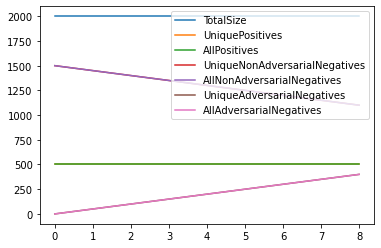

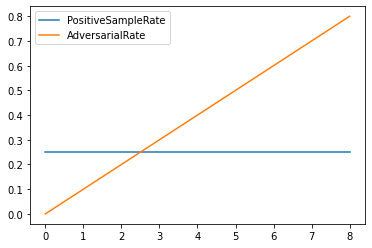

In [21]:
create_samples_adversarial_and_upload_to_s3(df_train_with_adversaries, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}")



s3://aegovan-data/self-supervised-fake-fixed-size/202212091954/affable/train_2000_500_0.json {'UniquePositives': 500, 'AllPositives': 500, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1500, 'AllNegatives': 1500, 'AffableNegatives': 0, 'AffableNegativeRate': 0.0, 'UniqueNonAdversarialNegatives': 1500, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 'UniqueAdversarialRate': 0.0, 'TotalSize': 2000, 'UniqueAbstracts': 2000}
s3://aegovan-data/self-supervised-fake-fixed-size/202212091954/affable/train_2000_500_150.json {'UniquePositives': 500, 'AllPositives': 500, 'UniquePositiveSampleRate': 0.25, 'PositiveSampleRate': 0.25, 'UniqueNegatives': 1350, 'AllNegatives': 1500, 'AffableNegatives': 150, 'AffableNegativeRate': 0.1, 'UniqueNonAdversarialNegatives': 1350, 'AllNonAdversarialNegatives': 1500, 'UniqueAdversarialNegatives': 0, 'AllAdversarialNegatives': 0, 'AdversarialRate': 0.0, 

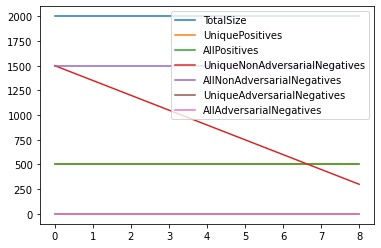

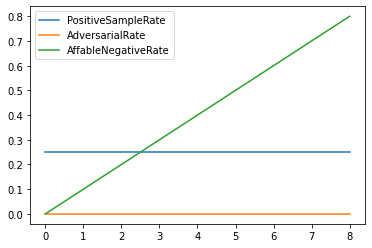

In [22]:
create_affable_negatives_and_upload_to_s3(df_train_random, pos_label=True, 
                                s3_uri_base=f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}")

In [23]:
upload_df_to_s3_json(df_val, f"s3://aegovan-data/self-supervised-fake-fixed-size/{datefmt}/val.json")